In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
plt.rcParams['ps.useafm'] = True
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import pandas as pd
import time
import shutil
import argparse
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/DATA/lucaa/software/CLoNe')

from clone import CLoNe
from plot import plot_clusters
from structural_utils import load_md_args, show_cluster_info

import mdtraj
import pyemma

print(__doc__)
start = time.time()


def calculate_pca(topo, traj, main_folder, syst, at_sel, n_pca ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    

    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers

    # Principal component analysis
    original_coords = coords.copy()
    pca_obj = PCA(n_components=n_pca)
    reddim_coords = pca_obj.fit_transform(coords)
    eigenvalues = pca_obj.explained_variance_ratio_
    ratio = np.sum(eigenvalues[:n_pca])
    pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
    print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
    print("sum of Variance: %s"%(np.sum(eigenvalues)))
    with open("%sPCA_coords.txt"%output_folder, "w") as f:
        for x in range(n_pca):
            f.write("PC%i(%.2f) "%(x + 1, eigenvalues[x]))
        f.write("\n")
        for el in reddim_coords:
            for n in el:
                f.write("%f "%n)
            f.write("\n")  
    return pca_obj, reddim_coords, original_coords


def calc_magn_vector(pc):
    final_length = int(len(pc)/3)
    pc_magn = np.empty(final_length)
    
    for i in range(final_length):
        pc_magn[i] = np.sqrt(pc[i*3]**2+pc[i*3+1]**2+pc[i*3+2]**2)
    
    return pc_magn


def save_pc_bfact(init_padding, length_pc, final_padding, structure, pc_component, outpdb):

    pc_elongated = np.concatenate((np.zeros(init_padding),calc_magn_vector(pc_component),np.zeros(final_padding)))
    system_length_res = len([residue for residue in structure.topology.residues])
    system_length_atoms = len([ atom for atom in structure.topology.atoms])

    syst_bfact=np.zeros(system_length_atoms)
    index=0
    for resid in range(system_length_res):
        res_len = len(structure.topology.select('resid '+str(resid)))
        res_bfact= res_len
        syst_bfact[index:index+res_len] = pc_elongated[resid]
        index += res_len

    structure[0].save_pdb(outpdb, bfactors=syst_bfact*100)
    
# Check convercence PC
def calculate_pca_convergence(topo, traj, main_folder, syst, at_sel, n_pca, nframes, nsim ):
    # Load trajectory
    topology = mdtraj.load(topo).topology
    struct_ens = mdtraj.load(traj, top=topo)

    # Create result folder based on dataset nam\e
    if not os.path.exists(main_folder):
        os.makedirs(main_folder)
    out_idx =  1
    output_folder = main_folder+"/%s_%i/"
    while os.path.exists(output_folder%(syst, out_idx)):
        out_idx += 1
    output_folder = output_folder%(syst, out_idx)
    os.makedirs(output_folder)
    
    selection = struct_ens.topology.select(at_sel)
    coords = struct_ens.xyz[:, selection]
    coords = coords.reshape(coords.shape[0], coords.shape[1] * coords.shape[2])
    headers = ["C%i"%x for x in range(len(coords[0]))]  # general headers
    
    frameslist = np.multiply(np.arange(1,nsim+1),nframes)
    original_coords = coords.copy()
    pcas_list = []
    reddim_coords_list = []
    print(np.shape(coords))
    # Principal component analysis
    for section in frameslist:
        pca_obj = PCA(n_components=n_pca)
        
        reddim_coords = pca_obj.fit_transform(coords[0:section])
        pcas_list.append(pca_obj)
        #eigenvalues = pca_obj.explained_variance_ratio_
        #ratio = np.sum(eigenvalues[:n_pca])
        #pca_headers = ["PC%i (%.2f)"%(x + 1, eigenvalues[x]) for x in range(n_pca)]
    
        #print("> PCA: %i => %i dimension(s) with eigenval.: %s"%(len(headers), n_pca, str(eigenvalues)))
        #print("sum of Variance: %s"%(np.sum(eigenvalues)))
  
    return pcas_list

Automatically created module for IPython interactive environment


In [2]:
# PARAMETERS SETUP

# Clustering parameters 
pdc=8  # neighbour search during clusterint
n_resize=4 
filt=0.1 
verbose=False
n_pca=10 # number of PC to include in calculations 
n_bins= 220  # number of bins for PC hist
# Simulations and topology 
trj_apoerg='apofromerg/trjcat_md_osh4_fromerg_apo_replica1to6_center_pbcmol_fit_rot_trans_CA_after10ns_every10thframe.xtc'   # apo traj
trj_apopi4p='apofrompi4p/trjcat_md_osh4_frompi4p_apo_replica1to6_center_pbcmol_fit_rot_trans_CA_after10ns_every10thframe.xtc'# holo traj
trj_tot='apo_combined.xtc'   # concatenated total traj

topo_apoerg='apofromerg/apo.gro'  # pdb or gro of apo
topo_apopi4p='apofrompi4p/apo.gro'  # pdb or gro of apo

# Selection for PCA calculation (see mdtraj syntax)
at_sel="name CA"  # try to exclude end loops or regions that move but are not interesting (hides the true PC)
n_res=434   # number of residues (still manual insertion, i know...)
feat="None"
resmin=1
resmax=434
output_folder = "results"

apoerg_name="apoerg"
apopi4p_name="apopi4p"
tot_name="tot"

In [3]:
# make results folder 
try:
    os.mkdir(output_folder)
except FileExistsError:
    pass
# make images folder 
try:
    os.mkdir(output_folder+'/IMAGES/')
except FileExistsError:
    pass
# Calculate PCA
pca_apoerg, red_dim_coords_apoerg, orig_coords_apoerg = calculate_pca(topo_apoerg, trj_apoerg, output_folder, apoerg_name, at_sel, n_pca)
pca_apopi4p, red_dim_coords_apopi4p, orig_coords_apopi4p = calculate_pca(topo_apopi4p, trj_apopi4p, output_folder, apopi4p_name, at_sel, n_pca)
pca_tot, red_dim_coords_tot, orig_coords_tot = calculate_pca(topo_apoerg, trj_tot, output_folder, tot_name, at_sel, n_pca)


> PCA: 1302 => 10 dimension(s) with eigenval.: [0.2144447  0.13825288 0.08313446 0.06724425 0.0619177  0.04653654
 0.04236741 0.0320905  0.02094879 0.01946767]
sum of Variance: 0.7264049
> PCA: 1302 => 10 dimension(s) with eigenval.: [0.38118064 0.1301691  0.07019241 0.05248499 0.0466113  0.03630571
 0.02830876 0.02195584 0.01897934 0.01837242]
sum of Variance: 0.80456054
> PCA: 1302 => 10 dimension(s) with eigenval.: [0.27008805 0.11130071 0.07493005 0.06271265 0.04730292 0.04141399
 0.03471547 0.03187364 0.02689891 0.02137279]
sum of Variance: 0.7226092


In [4]:
index_apo_end=np.shape(red_dim_coords_apoerg)[0]
index_tot_end=np.shape(red_dim_coords_tot)[0]

# Figures PC and histograms checking that all pc apo, holo and tot are the similar 

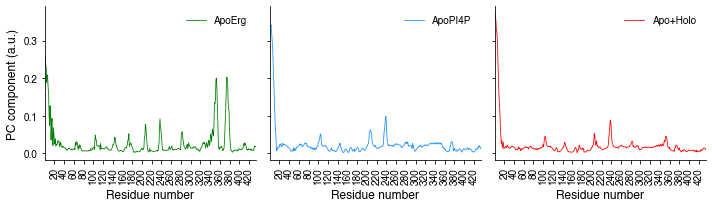

In [20]:
fig, ax = plt.subplots(1,3, figsize=(10,3), sharey=True, sharex=True)
tick_spacing = 20
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax[0].tick_params(axis='x', rotation=90)
ax[1].tick_params(axis='x', rotation=90)
ax[2].tick_params(axis='x', rotation=90)

ax[0].set_xlim(resmin,resmax)
ax[0].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_apoerg.components_[0]), linewidth=0.8, color='green')
ax[1].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_apopi4p.components_[0]), linewidth=0.8, color='dodgerblue')
ax[2].plot(np.arange(resmin, resmax+1),calc_magn_vector(pca_tot.components_[0]), linewidth=0.8, color='red')

sns.despine()

ax[0].legend(['ApoErg'], frameon=False)
ax[1].legend(['ApoPI4P'], frameon=False)
ax[2].legend(['Apo+Holo'], frameon=False)

ax[0].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[1].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[2].set_xlabel("Residue number", fontsize=12, labelpad=5)
ax[0].set_ylabel("PC component (a.u.)", fontsize=12, labelpad=5)
fig.tight_layout()

fig.savefig(output_folder+'/IMAGES/comparison_pc_apo_holo_tot.pdf')

plt.show()

/DATA/lucaa/software/anaconda3/envs/cloneenv/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


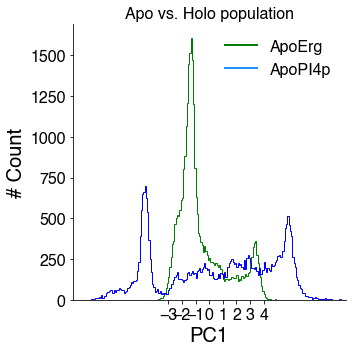

In [23]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

min_pc = -10
max_pc = 10

sns.despine()
ax.set_xlim([min_pc,max_pc])
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("# Count", fontsize=20)

ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, histtype="step")
ax.hist(red_dim_coords_tot[index_apo_end:,0], color='blue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
#ax.hist(red_dim_coords_tot[0:index_apo_end,0], color='green', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

#ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, histtype="step")
#ax.hist(red_dim_coords_tot[index_apo_end:index_tot_end,0], color='dodgerblue', range=(min_pc, max_pc), bins=n_bins, alpha=0.3)

legend_elements = [Line2D([0], [0], color='green', lw=2, label='ApoErg'),Line2D([0], [0], color='dodgerblue', lw=2, label='ApoPI4p')]
ax.legend(['ApoErg','ApoPI4p'], frameon=False, fontsize=16, handles = legend_elements)
ax.set_title("Apo vs. Holo population", fontsize=16)

fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/histograms_pc.pdf')
plt.show()

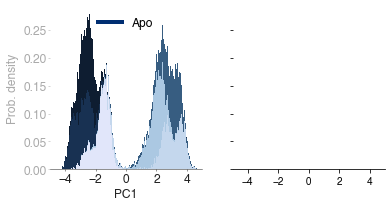

In [7]:
new_data = (red_dim_coords_apo[0:29400,0].reshape(6,4900))
#new_data_holo = (red_dim_coords_tot[29400:58800,0].reshape(6,4900))

fig, ax1 = plt.subplots(1, 2, figsize=(6,3), sharex=True, sharey=True )
color_list = np.array(['#E1E6FA','#C4D7ED','#ABC8E2','#375D81','#183152','#0e1d31'])
color_list2 = np.array(['#e8f7e2','#d0eec5','#b9e6a8','#8ad56d','#5ec137','#418626'])
color_list3=np.array(['#ffc0c3','#ffa1a5','#ff8186','#ff6268','#ff424a','#ff222c',
                      '#ff030e','#e3000a','#c30008','#a30007','#840006','#650004'])
color_list4=np.array(['#def3d5','#cdedc1','#bce7ac','#ace197','#9bdb82','#8ad56d',
                      '#7acf58','#69c944','#5bbc36','#51a730','#47932a','#3d7e24'])
color_list5=np.array(['#c2dbff','#a3c9ff','#85b7ff','#67a5ff','#4893ff','#2a81ff',
                      '#0b6fff','#0060ec','#0054cd','#0047af','#003b90','#002e72'])

min_pc = -5
max_pc = 5
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}

sns.despine(left=True)

#PLOT 1 
ax1[0].set_xlim([min_pc,max_pc])
#ax1[0].set_ylim([0,1.5])
ax1[0].set_xticks([-4,-2,0,2,4])
#ax1[0].set_yticks([0,0.5, 1,1.5])
ax1[0].set_xlabel("PC1", fontsize=12, labelpad=3)
ax1[0].set_ylabel("Prob. density", fontsize=12)
ax1[0].tick_params(axis = 'both', which = 'major', labelsize =12, pad=1.5, length=2)
ax1[0].tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1[0].spines[axis].set_linewidth(0.5)
# axes colors
ax1[0].xaxis.label.set_color(axcolor)
ax1[0].yaxis.label.set_color(axcolor2)         
ax1[0].tick_params(axis='x', colors=axcolor)    
ax1[0].tick_params(axis='y', colors=axcolor2)  
ax1[0].spines['left'].set_color(axcolor2)
ax1[0].spines['bottom'].set_color(axcolor)  

ax1[0].hist(new_data[0:6].T, range=(min_pc, max_pc), bins=n_bins, histtype="bar", stacked=True, zorder=-1, density=True, linewidth=0.2, color=color_list)
#ax1[1].hist(new_data_holo[0:6].T, range=(min_pc, max_pc), bins=n_bins, histtype="bar", stacked=True, zorder=-1, density=True, linewidth=0.2, color=color_list2)

#ax1.hist(red_dim_coords_apo[:,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.3, density=True, linewidth=0.2)
custom_lines = [Line2D([0], [0], color='#002e72', lw=4)]
ax1[0].legend(custom_lines, ['Apo', 'Holo'], frameon=False, fontsize=12)

#plt.show()
fig.savefig(output_folder+'/IMAGES/hist_convergence.png', dpi=600, bbox_inches='tight')

In [6]:
nframes=4900
nsim=6
pc_list_conv = calculate_pca_convergence(topo_apo, trj_apo, output_folder, apo_name, at_sel, n_pca, nframes, nsim)
product=[0]*6
for i in range(6):
    product[i] = np.dot(pc_list_conv[i].components_[0],pc_list_conv[5].components_[0])
    
print(product)

(29401, 477)
[-0.2830825, 0.91736984, -0.9089627, -0.917364, -0.9957702, 1.0]


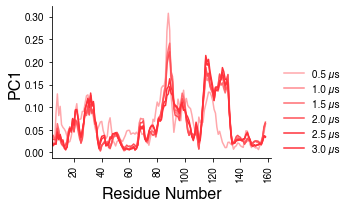

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
tick_spacing = 20
sns.despine()
color_list = ['#ffa7ab','#ff898f','#ff6c72','#ff4f56','#ff313a','#ff313a','#ff141e','#f5000b','#d80009','#bb0008','#9d0007','#800006','#620004']
ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax1.tick_params(axis='x', rotation=90)
ax1.set_xlim(resmin,resmax)
ax1.set_ylabel("PC1", fontsize=16, labelpad=3)
ax1.set_xlabel("Residue Number", fontsize=16)

ax1.plot(calc_magn_vector(pc_list_conv[0].components_[0]), color=color_list[0])
ax1.plot(calc_magn_vector(pc_list_conv[1].components_[0]), color=color_list[1])
ax1.plot(calc_magn_vector(pc_list_conv[2].components_[0]), color=color_list[2])
ax1.plot(calc_magn_vector(pc_list_conv[3].components_[0]), color=color_list[3])
ax1.plot(calc_magn_vector(pc_list_conv[4].components_[0]), color=color_list[4])
ax1.plot(calc_magn_vector(pc_list_conv[5].components_[0]), color=color_list[5])

ax1.legend(['0.5 \u00b5s','1.0 \u00b5s','1.5 \u00b5s','2.0 \u00b5s','2.5 \u00b5s','3.0 \u00b5s',
            '3.5 \u00b5s','4.0 \u00b5s','4.5 \u00b5s','5.0 \u00b5s','5.5 \u00b5s','6.0 \u00b5s'], frameon=False, loc=(1.04,0) )



fig.tight_layout()
fig.savefig('pc_conv.png')

# Clustering


In [5]:
clone_apo = CLoNe(pdc=15)
#clone_holo = CLoNe(pdc=pdc)
#clone_apoholo = CLoNe(pdc=pdb)

clone_apo.fit(red_dim_coords_apo[0:index_apo_end,0].reshape(-1, 1)) 
#clone_holo.fit(red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1)) 
#clone_apoholo.fit(red_dim_coords_tot[:,0].reshape(-1, 1)) 

NameError: name 'red_dim_coords_apo' is not defined

In [42]:
np.shape(red_dim_coords_apo[1:,0].reshape(4900,6))

(4900, 6)

# Population analysis

In [7]:
clusters = np.unique(clone_apoholo.labels_)
labels_apo = clone_apoholo.labels_[0:index_apo_end]
labels_holo = clone_apoholo.labels_[index_apo_end:index_tot_end]
pop_list = []
for label in clusters:
    
    count_apo = np.count_nonzero(labels_apo == label)
    count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apoholo.labels_[0:index_tot_end] == label)
    pop_list.append([label, count_apo/count_tot*100, count_holo/count_tot*100, count_tot/len(clone_apoholo.labels_)*100])
    #print(label, count_apo, count_holo, count_tot)

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'frames holo (%)', 'cluster relevance (%)'])  

df.to_csv(output_folder+'/'+tot_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

NameError: name 'clone_apoholo' is not defined

# Cluster plots

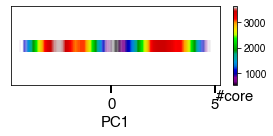

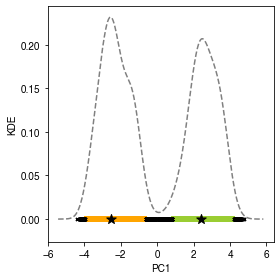

In [6]:
pca_headers = ["PC%i"%(x + 1) for x in range(n_pca)]
plot_clusters(clone_apo, red_dim_coords_apo[0:index_apo_end,0].reshape(-1, 1), output_folder+'/apo_1',pca_headers[:2] ) 
#plot_clusters(clone_holo, red_dim_coords_tot[index_apo_end:index_tot_end,0].reshape(-1, 1), output_folder+'/holo_1',pca_headers[:2] )
#plot_clusters(clone_apoholo, red_dim_coords_tot[:,0].reshape(-1, 1), output_folder+'/'+tot_name+'_1',pca_headers[:2] )

# Save clusters

In [12]:
# Load trajectories
struct_apo = mdtraj.load(trj_apo, top=topo_apo)
#struct_holo = mdtraj.load(trj_holo, top=topo_apo)
#struct_apoholo = mdtraj.load(trj_tot, top=topo_apo

In [12]:
unique_labels = range(len(clone_apo.centers)) 
folder = output_folder+'/'+apo_name+'_1'

# Save center
[struct_apo[center].save(folder+"/Center_%d.pdb"%(center_id + 1)) for center, center_id in zip(clone_apo.centers, unique_labels)]
# Save trajs
[struct_apo[clone_apo.labels_[0:index_apo_end] == lab].save(folder+"/Cluster_apo_%d.xtc"%(lab + 1)) for lab in unique_labels]
#[struct_holo[clone_apoholo.labels_[index_apo_end:] == lab].save(folder+"/Cluster_holo_%d.xtc"%(lab + 1)) for lab in unique_labels]

[None, None, None]

# Save extreme structures

In [13]:
minframe=[100,-1,-2]
maxframe=[-100,-1,-2]
for frame in zip(red_dim_coords_apo[:,0].reshape(-1, 1), clone_apo.labels_, range(len(clone_apo.labels_))):
    if frame[1] != -1:
        if frame[0] < minframe[0]:
            minframe = frame
        if frame[0] > maxframe[0]:
            maxframe = frame

folder = output_folder+'/'+apo_name+'_1'
struct_apo[minframe[2]].save(folder+"/extremeleft.pdb")          
struct_apo[maxframe[2]].save(folder+"/extremeright.pdb") 

In [15]:
a = sorted(zip(red_dim_coords_apo[:,0].reshape(-1, 1), clone_apo.labels_, range(len(clone_apo.labels_))))
a = [el for el in a if el[1] != -1]
a[0]
struct_apo[a[0][2]].save(folder+"/extremeleft1.pdb")
struct_apo[a[1][2]].save(folder+"/extremeleft2.pdb")
struct_apo[a[2][2]].save(folder+"/extremeleft3.pdb")
struct_apo[a[3][2]].save(folder+"/extremeleft4.pdb")
struct_apo[a[4][2]].save(folder+"/extremeleft5.pdb")
struct_apo[a[5][2]].save(folder+"/extremeleft6.pdb")
struct_apo[a[6][2]].save(folder+"/extremeleft7.pdb")
struct_apo[a[7][2]].save(folder+"/extremeleft8.pdb")
struct_apo[a[8][2]].save(folder+"/extremeleft9.pdb")
struct_apo[a[9][2]].save(folder+"/extremeleft10.pdb")
struct_apo[a[10][2]].save(folder+"/extremeleft11.pdb")
struct_apo[a[11][2]].save(folder+"/extremeleft12.pdb")
struct_apo[a[12][2]].save(folder+"/extremeleft13.pdb")
struct_apo[a[13][2]].save(folder+"/extremeleft14.pdb")
struct_apo[a[14][2]].save(folder+"/extremeleft15.pdb")
struct_apo[a[15][2]].save(folder+"/extremeleft16.pdb")
struct_apo[a[16][2]].save(folder+"/extremeleft17.pdb")
struct_apo[a[17][2]].save(folder+"/extremeleft18.pdb")
struct_apo[a[18][2]].save(folder+"/extremeleft19.pdb")
struct_apo[a[19][2]].save(folder+"/extremeleft20.pdb")

struct_apo[a[-1][2]].save(folder+"/extremeright1.pdb")
struct_apo[a[-2][2]].save(folder+"/extremeright2.pdb")
struct_apo[a[-3][2]].save(folder+"/extremeright3.pdb")
struct_apo[a[-4][2]].save(folder+"/extremeright4.pdb") 
struct_apo[a[-5][2]].save(folder+"/extremeright5.pdb")
struct_apo[a[-6][2]].save(folder+"/extremeright6.pdb")
struct_apo[a[-7][2]].save(folder+"/extremeright7.pdb")
struct_apo[a[-8][2]].save(folder+"/extremeright8.pdb")
struct_apo[a[-9][2]].save(folder+"/extremeright9.pdb") 
struct_apo[a[-10][2]].save(folder+"/extremeright10.pdb")
struct_apo[a[-11][2]].save(folder+"/extremeright11.pdb")
struct_apo[a[-12][2]].save(folder+"/extremeright12.pdb")
struct_apo[a[-13][2]].save(folder+"/extremeright13.pdb")
struct_apo[a[-14][2]].save(folder+"/extremeright14.pdb") 
struct_apo[a[-15][2]].save(folder+"/extremeright15.pdb")
struct_apo[a[-16][2]].save(folder+"/extremeright16.pdb")
struct_apo[a[-17][2]].save(folder+"/extremeright17.pdb")
struct_apo[a[-18][2]].save(folder+"/extremeright18.pdb")
struct_apo[a[-19][2]].save(folder+"/extremeright19.pdb") 
struct_apo[a[-20][2]].save(folder+"/extremeright20.pdb")

 # Save  PC in B-fact

In [15]:
folder = output_folder
save_pc_bfact(3,158,3,struct_apo, pca_apo.components_[0],folder+"/IMAGES/gm2a_apo_pc0.pdb")
#save_pc_bfact(2,199,5,struct_apo, pca_holo.components_[0],folder+"/IMAGES/gm2a_holo_pc0.pdb")
#save_pc_bfact(2,199,5,struct_apo, pca_tot.components_[0],folder+"/IMAGES/gm2a_apoholo_pc0.pdb")

# HISTOGRAM FOR MAIN FIGURE


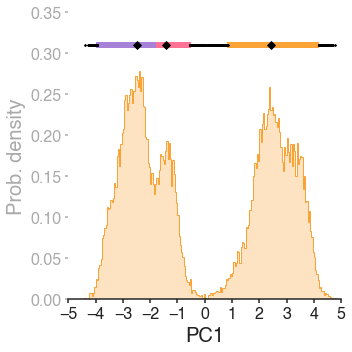

In [11]:
from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm

def plot_clusters_formainfig(clone, data, path, headers=None):
    color_list = np.array(['#ff7295','#faa336','#a782d9' ])
    colors = np.array(list(islice(cycle(color_list),len(clone.centers))))
    
    fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True, sharex=True)

    min_pc = -5
    max_pc = 5

    sns.despine(left=True)
    ax.set_xlim([min_pc,max_pc])
    ax.set_ylim([0,0.35])

    ax.set_xticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.set_xlabel("PC1", fontsize=20, labelpad=5)
    ax.set_ylabel("Prob. density", fontsize=20)
    
    # change all spines
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)
    # increase tick width
    axcolor = '#222222'
    axcolor2 = '#AAAAAA'
    ax.tick_params(width=1.5)
    ax.xaxis.label.set_color(axcolor)        #setting up X-axis label color to yellow
    ax.yaxis.label.set_color(axcolor2)          #setting up Y-axis label color to blue
    ax.tick_params(axis='x', colors=axcolor)    #setting up X-axis tick color to red
    ax.tick_params(axis='y', colors=axcolor2)    #setting up X-axis tick color to red

    ax.spines['left'].set_color(axcolor2)        # setting up Y-axis tick color to red
    ax.spines['bottom'].set_color(axcolor)  
    
    centers = np.array(clone.centers)
    labels = np.array(clone.labels_)
    labels_all = np.array(clone.labels_all)
    core = clone.core_card
    rho = clone.rho

    ax.hist(red_dim_coords_apo[0:,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True)
    ax.hist(red_dim_coords_apo[0:,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.3, density=True)
    
    # Mask for plotting
    assigned_mask = np.where(labels != -1)
    outliers_mask = np.where(labels == -1)

    # Sort some values for better visualization after
    arcore = np.argsort(core)
    s_cores = core[arcore]
    s_x = data[arcore]
    
    ypos=[0.31]
    # Plot clusters
    ax.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', color=colors[labels[assigned_mask]], zorder=1, clip_on=False)
    ax.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='D', s=2, color='black', zorder=1, clip_on=False)
    ax.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=30, color='black', zorder=1, clip_on=False)


    fig.tight_layout()
    fig.savefig(output_folder+'/IMAGES/histograms_pc_clustering_mainfig.pdf', dpi=600)
    plt.show()

    
plot_clusters_formainfig(clone_apo, red_dim_coords_apo[:,0].reshape(-1, 1), output_folder+'/'+tot_name+'_1',pca_headers[:2] )

0 100.0 46.042651610489436 46.042651610489436
1 99.99349381912818 52.27713343083569 52.273732185980066
-1 100.0 1.680214958674875 1.680214958674875


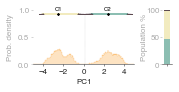

In [8]:
from itertools import islice, cycle
import statsmodels.api as sm
import matplotlib.cm as cm

clusters = np.unique(clone_apo.labels_)
labels_apo = clone_apo.labels_[0:29400]
pop_list = []
for label in [0,1,-1]:
    count_apo = np.count_nonzero(labels_apo == label)
    #count_holo = np.count_nonzero(labels_holo == label)
    count_tot= np.count_nonzero(clone_apo.labels_[:] == label)
    pop_list.append([label, count_apo/count_tot*100, count_tot/len(clone_apo.labels_)*100, count_apo/count_tot*100*count_tot/len(clone_apo.labels_)])
    print(label, count_apo/count_tot*100, count_tot/len(clone_apo.labels_)*100, count_apo/count_tot*100*count_tot/len(clone_apo.labels_))

df = pd.DataFrame(pop_list, columns=['cluster', 'frames apo (%)', 'cluster relevance (%)', 'weighted_cluster_relevance_apo'])  
df.to_csv(output_folder+'/'+apo_name+"_1/population_analysis.txt", sep=" ", float_format="%2.2f")

fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 0.4]}, figsize=(2.5,1), )
plt.subplots_adjust(wspace=0.5)
color_list = np.array(['#8CBEB2','#F2EBBF','#f49090', "#5C4B51"])
colors = np.array(list(islice(cycle(color_list),len(clone_apo.centers))))
min_pc = -5
max_pc = 5
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}

centers = np.array(clone_apo.centers)
labels = np.array(clone_apo.labels_)
labels_all = np.array(clone_apo.labels_all)
core = clone_apo.core_card

sns.despine(left=True)

#PLOT 1 
ax1.set_xlim([min_pc,max_pc])
ax1.set_ylim([0,1])
ax1.set_xticks([-4,-2,0,2,4])
ax1.set_yticks([0,0.5, 1])
ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel("Prob. density", fontsize=8)

ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor2)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor2)  
ax1.spines['left'].set_color(axcolor2)
ax1.spines['bottom'].set_color(axcolor)  
    
ax1.hist(red_dim_coords_apo[:,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="step", zorder=-1, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_apo[:,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.3, density=True, linewidth=0.2)
    
# Mask for plotting
assigned_mask = np.where(labels != -1)
outliers_mask = np.where(labels == -1)

# Sort some values for better visualization after
data = red_dim_coords_apo[:,0].reshape(-1, 1)
arcore = np.argsort(core)
s_cores = core[arcore]
s_x = data[arcore]

ypos=[0.92]
# Plot clusters
ax1.axvline(x=0.1, color='#AAAAAA', linestyle='--', ymax=ypos[0], linewidth=0.2, zorder=-1)
#ax1.axvline(x=-0.87, color='#AAAAAA', linestyle='--', ymax=ypos[0], linewidth=0.2, zorder=-1)

ax1.scatter(data[assigned_mask, 0], ypos * len(data[assigned_mask]), marker='|', s=3, color=colors[labels[assigned_mask]], zorder=1, clip_on=False)
ax1.scatter(data[outliers_mask, 0], ypos * len(data[outliers_mask]), marker='*', s=0.02, color=color_list[3], zorder=1, clip_on=False)
ax1.scatter(data[centers, 0], ypos * len(data[centers]), marker='D', s=2, color='black', zorder=1, clip_on=False)

ax1.text(-2.90,0.99, "C1", fontsize=6)
ax1.text(2.0,0.99, "C2", fontsize=6)
#ax1.text(1.8,0.99, "C3", fontsize=8)

#PLOT 2 
ax2.set_ylim([0,100])
ax2.set_xticks([0,1])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1, length=2)
ax2.set_ylabel("Population %", fontsize=8, labelpad=-2, **hfont)
    
# set colors 
ax2.tick_params(width=0.5)
ax2.xaxis.label.set_color(axcolor)       
ax2.yaxis.label.set_color(axcolor2)          
ax2.tick_params(axis='x', colors=axcolor) 
ax2.tick_params(axis='y', colors=axcolor2)
ax2.spines['left'].set_color(axcolor2)        
ax2.spines['bottom'].set_color(axcolor)  
# change all spines
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(0.5)


new_df = df[['weighted_cluster_relevance_apo']]
new_df.transpose().plot(kind='bar', legend=False, width=0.8, ax=ax2, color=[color_list[0], color_list[1], color_list[3]], stacked=True)

ax2.set_xticklabels([""], rotation = 90, ha='center',**hfont, fontsize=8)


#fig.tight_layout()
fig.savefig(output_folder+'/IMAGES/total_figure.png', dpi=1200, bbox_inches='tight')

In [9]:
new_data = red_dim_coords_apo[1:,0].reshape(6,4900)

In [18]:
np.shape(new_data[0:3].T)

(4900, 3)

NameError: name 'new_data' is not defined

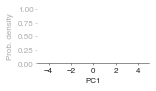

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(2,1) )
color_list = np.array(['#68a92e','#bbe398','#88ce4b'])
min_pc = -5
max_pc = 5
axcolor = '#222222'
axcolor2 = '#AAAAAA'
hfont = {'fontname':'Helvetica'}

sns.despine(left=True)

#PLOT 1 
ax1.set_xlim([min_pc,max_pc])
ax1.set_ylim([0,1])
ax1.set_xticks([-4,-2,0,2,4])
ax1.set_yticks([0,0.25,0.5,0.75, 1])
ax1.set_xlabel("PC1", fontsize=8, labelpad=3)
ax1.set_ylabel("Prob. density", fontsize=8)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 8, pad=1.5, length=2)
ax1.tick_params(width=0.5)
# change all spines
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(0.5)
# axes colors
ax1.xaxis.label.set_color(axcolor)
ax1.yaxis.label.set_color(axcolor2)         
ax1.tick_params(axis='x', colors=axcolor)    
ax1.tick_params(axis='y', colors=axcolor2)  
ax1.spines['left'].set_color(axcolor2)
ax1.spines['bottom'].set_color(axcolor)  

ax1.hist(new_data[0:6].T, range=(min_pc, max_pc), bins=n_bins, histtype="bar", stacked=True, zorder=-1, density=True, linewidth=0.2)
ax1.hist(red_dim_coords_apo[:,0], color='#FAA336', range=(min_pc, max_pc), bins=n_bins, histtype="stepfilled", zorder=-1, alpha=0.3, density=True, linewidth=0.2)
    
#plt.show()
fig.savefig(output_folder+'/IMAGES/convergence.png', dpi=600, bbox_inches='tight')